In [401]:
import numpy as np
import matplotlib.pyplot as plt

# Requirement 3

In [402]:
# Non stationary env for tarification pb
class NonStationaryPricingEnvironment:
    def __init__(self, num_days, price_levels, intervals):
        self.num_days = num_days
        self.price_levels = price_levels
        self.intervals = intervals
        self.demand_curves = self._generate_demand_curves()
        self.noise_level = 5  # Noise level

    def _generate_demand_curves(self):
        demand_curves = {}
        for start, end in self.intervals:
            slope = -np.random.rand() * 100
            intercept = np.random.rand() * 300
            demand_curves[(start, end)] = lambda p: max(0, intercept + slope * p)
        return demand_curves

    def get_demand(self, day, price):
        for (start, end), demand_curve in self.demand_curves.items():
            if start <= day < end:
                demand = demand_curve(price)
                return max(0, demand + np.random.normal(0, self.noise_level))
        return 0


In [403]:
import math
# Sliding-Window
class SlidingWindowPricing:
    def __init__(self, price_levels, window_size, exploration_period=200, random_reset_interval=100, exploration_rate=0.1):
        self.price_levels = price_levels
        self.window_size = window_size
        self.history = []
        self.exploration_period = exploration_period  # Exploration period
        self.exploration_rate = exploration_rate
        self.random_reset_interval = random_reset_interval  # We need to reexplore regularly

    def update_history(self, price, demand):
        self.history.append((price, demand))
        if len(self.history) > self.window_size:
            self.history.pop(0)

    def get_optimal_price(self, day):
        # Exploration
        if np.random.random() < self.exploration_rate:
            return np.random.choice(self.price_levels)
        
        # If we haven't tried all prices yet, try the next untried price
        if len(self.history) < len(self.price_levels):
            return self.price_levels[len(self.history)]

        total_weight = sum(range(1, len(self.history) + 1))
        avg_demand = {price: 0 for price in self.price_levels}
        count = {price: 0 for price in self.price_levels}

        # Calculate weighted average demand
        for i, (price, demand) in enumerate(self.history):
            weight = (i + 1) / total_weight
            avg_demand[price] += demand * weight
            count[price] += weight

        total_trials = len(self.history)
        ucb_values = {}

        # Calculate UCB values
        for price in self.price_levels:
            if count[price] > 0:
                avg = avg_demand[price] / count[price]
                exploration_term = math.sqrt(2 * math.log(total_trials) / count[price])
                ucb = avg + exploration_term
                ucb_values[price] = price * ucb
            else:
                ucb_values[price] = float('inf')  # Encourage exploring untried prices

        optimal_price = max(ucb_values, key=ucb_values.get)
        
        # Avoid zero prices
        if optimal_price == 0:
            return np.random.choice(self.price_levels[1:])
        
        return optimal_price


In [404]:

# CUSUM
class CUSUMPricing:
    def __init__(self, price_levels, threshold, drift, exploration_rate=0.1, window_size=50):
        self.price_levels = price_levels
        self.threshold = threshold
        self.drift = drift
        self.exploration_rate = exploration_rate
        self.window_size = window_size
        self.history = {price: [] for price in price_levels}
        self.cusum_stat = {price: {'positive': 0, 'negative': 0} for price in price_levels}
        self.total_trials = 0

    def update_history(self, price, demand):
        self.history[price].append(demand)
        self.total_trials += 1
        if len(self.history[price]) > self.window_size:
            self.history[price].pop(0)
        
        if len(self.history[price]) > 1:
            mean = np.mean(self.history[price][:-1])
            change = demand - mean
            self.cusum_stat[price]['positive'] = max(0, self.cusum_stat[price]['positive'] + change - self.drift)
            self.cusum_stat[price]['negative'] = max(0, self.cusum_stat[price]['negative'] - change - self.drift)
            
            if self.cusum_stat[price]['positive'] > self.threshold or self.cusum_stat[price]['negative'] > self.threshold:
                self.history[price] = []
                self.cusum_stat[price] = {'positive': 0, 'negative': 0}

    def get_optimal_price(self):
        # Exploration
        if np.random.random() < self.exploration_rate:
            return np.random.choice(self.price_levels)
        
        # If we haven't tried all prices yet, try the next untried price
        untried_prices = [p for p in self.price_levels if len(self.history[p]) == 0]
        if untried_prices:
            return np.random.choice(untried_prices)

        ucb_values = {}
        for price in self.price_levels:
            if len(self.history[price]) > 0:
                avg_demand = np.mean(self.history[price])
                count = len(self.history[price])
                exploration_term = np.sqrt(2 * np.log(self.total_trials) / count)
                ucb = avg_demand + exploration_term
                ucb_values[price] = price * ucb
            else:
                ucb_values[price] = float('inf')

        optimal_price = max(ucb_values, key=ucb_values.get)
        return optimal_price


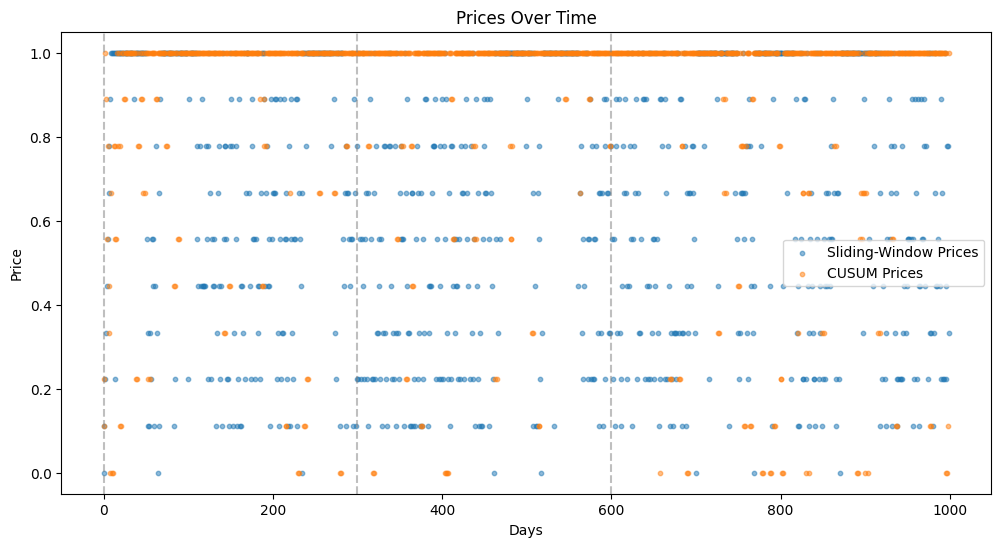

Total revenue for Sliding-Window strategy: 139378.83416536183
Total revenue for CUSUM strategy: 180513.06926036294


In [405]:

#Simlation of the interaction
def run_pricing_simulation(num_days, price_levels, intervals, window_size, cusum_threshold, cusum_drift):
    environment = NonStationaryPricingEnvironment(num_days, price_levels, intervals)
    sliding_window_strategy = SlidingWindowPricing(price_levels, window_size)
    cusum_strategy = CUSUMPricing(price_levels, cusum_threshold, cusum_drift)

    sliding_window_prices = []
    cusum_prices = []

    sliding_window_revenue = 0
    cusum_revenue = 0

    for day in range(num_days):
        # Update with Sliding-Window
        sliding_price = sliding_window_strategy.get_optimal_price(day)
        sliding_demand = environment.get_demand(day, sliding_price)
        sliding_window_strategy.update_history(sliding_price, sliding_demand)
        sliding_window_prices.append(sliding_price)
        sliding_window_revenue += sliding_price * sliding_demand

        # Update with CUSUM
        cusum_price = cusum_strategy.get_optimal_price()
        cusum_demand = environment.get_demand(day, cusum_price)
        cusum_strategy.update_history(cusum_price, cusum_demand)
        cusum_prices.append(cusum_price)
        cusum_revenue += cusum_price * cusum_demand

    return sliding_window_prices, cusum_prices, sliding_window_revenue, cusum_revenue

# Parameters
num_days = 1000
price_levels = np.linspace(0, 1, 10)
intervals = [(0, 300), (300, 600), (600, 1000)]
window_size = 50
cusum_threshold = 0.5
cusum_drift = 0.1

# Simulation
sliding_window_prices, cusum_prices, sliding_window_revenue, cusum_revenue = run_pricing_simulation(num_days, price_levels, intervals, window_size, cusum_threshold, cusum_drift)

# We print the results
plt.figure(figsize=(12, 6))
plt.scatter(range(num_days), sliding_window_prices, label='Sliding-Window Prices', alpha=0.5, s=10)
plt.scatter(range(num_days), cusum_prices, label='CUSUM Prices', alpha=0.5, s=10)
for interval in intervals:
    plt.axvline(x=interval[0], color='gray', linestyle='--', alpha=0.5)
plt.title('Prices Over Time')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display of total rewards
print(f"Total revenue for Sliding-Window strategy: {sliding_window_revenue}")
print(f"Total revenue for CUSUM strategy: {cusum_revenue}")


Total revenue for Clairvoyant strategy: 169478.5451631565


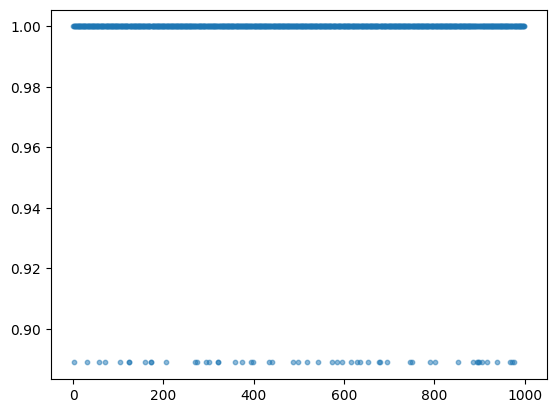

In [406]:
def get_clairvoyant_rewards(environment, price_levels):
    clairvoyant_prices = []
    clairvoyant_revenue = 0

    for day in range(environment.num_days):
        best_price = max(price_levels, key=lambda p: p * environment.get_demand(day, p))
        best_demand = environment.get_demand(day, best_price)
        clairvoyant_prices.append(best_price)
        clairvoyant_revenue += best_price * best_demand

    return clairvoyant_prices, clairvoyant_revenue

environment = NonStationaryPricingEnvironment(num_days, price_levels, intervals)
clairvoyant_prices, clairvoyant_revenue = get_clairvoyant_rewards(environment, price_levels)

plt.scatter(range(num_days), clairvoyant_prices, label='Clairvoyant Prices', alpha=0.5, s=10)

print(f"Total revenue for Clairvoyant strategy: {clairvoyant_revenue}")


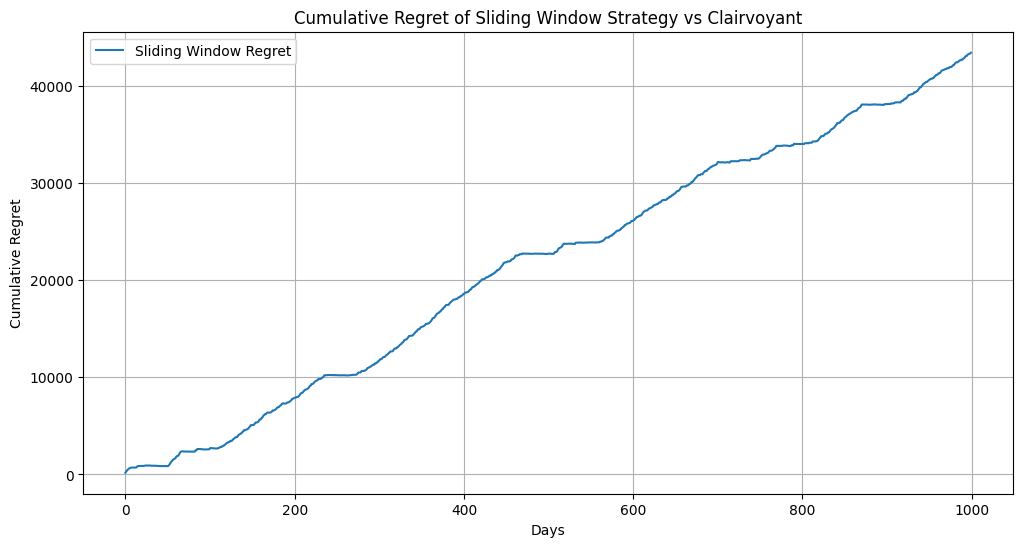

Final regret of Sliding Window strategy: 43400.325890287015


In [407]:
# Calculate cumulative rewards for both strategies
cumulative_sliding_window = np.cumsum([p * environment.get_demand(d, p) for d, p in enumerate(sliding_window_prices)])
cumulative_clairvoyant = np.cumsum([p * environment.get_demand(d, p) for d, p in enumerate(clairvoyant_prices)])

# Calculate regret
regret = cumulative_clairvoyant - cumulative_sliding_window

# Plot regret
plt.figure(figsize=(12, 6))
plt.plot(regret, label='Sliding Window Regret')
plt.title('Cumulative Regret of Sliding Window Strategy vs Clairvoyant')
plt.xlabel('Days')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

# Print final regret
print(f"Final regret of Sliding Window strategy: {regret[-1]}")

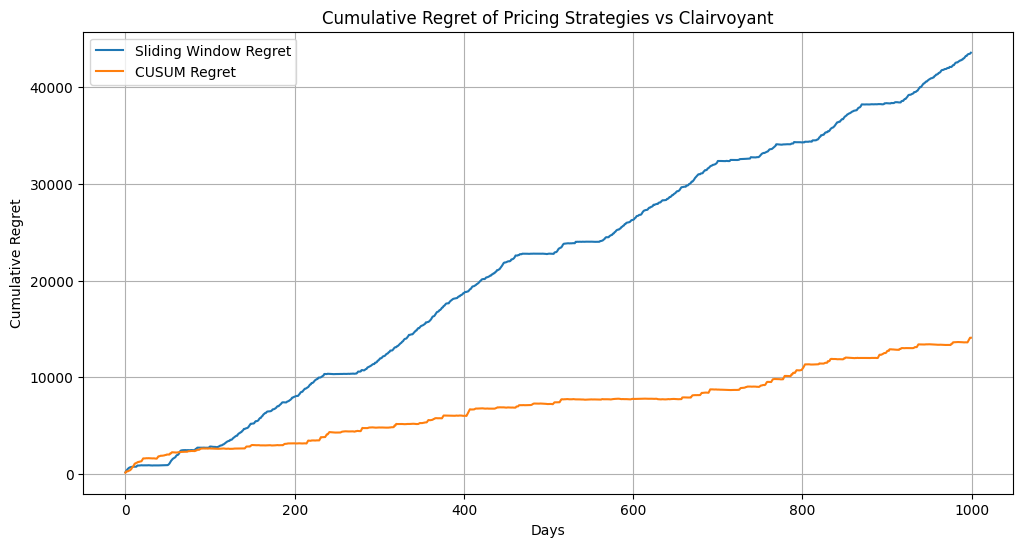

Final regret of Sliding Window strategy: 43568.85435009269
Final regret of CUSUM strategy: 14080.41659753141


In [408]:
# Calculate cumulative rewards for all strategies
cumulative_sliding_window = np.cumsum([p * environment.get_demand(d, p) for d, p in enumerate(sliding_window_prices)])
cumulative_cusum = np.cumsum([p * environment.get_demand(d, p) for d, p in enumerate(cusum_prices)])
cumulative_clairvoyant = np.cumsum([p * environment.get_demand(d, p) for d, p in enumerate(clairvoyant_prices)])

# Calculate regret for both strategies
regret_sliding_window = cumulative_clairvoyant - cumulative_sliding_window
regret_cusum = cumulative_clairvoyant - cumulative_cusum

# Plot regret
plt.figure(figsize=(12, 6))
plt.plot(regret_sliding_window, label='Sliding Window Regret')
plt.plot(regret_cusum, label='CUSUM Regret')
plt.title('Cumulative Regret of Pricing Strategies vs Clairvoyant')
plt.xlabel('Days')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

# Print final regrets
print(f"Final regret of Sliding Window strategy: {regret_sliding_window[-1]}")
print(f"Final regret of CUSUM strategy: {regret_cusum[-1]}")